## Transfer Learning
- Wifi y LTE
- pytorch


In [1]:
#Listo las carpetas que contiene el dataset
!ls '/home/student1/notebook/dataset/teleco_signal/'

ls: cannot access '/home/student1/notebook/dataset/teleco_signal/': No such file or directory


In [2]:
#Verifico la capacidad de GPU
!nvidia-smi

Sun Nov 24 15:57:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.01             Driver Version: 537.70       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   37C    P8               1W /  85W |   3270MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
#Librerias a importar
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import copy

Carga de las imágenes para entrenamiento

La normalizacion de las imágenes utiliza datos de Imagenet [0.485, 0.456, 0.406],                       [0.229, 0.224, 0.225]

Para val se añadio data augmentation, al tener pocas imagenes.

In [4]:
# Cargar las imagenes - datset

train_dataset = torchvision.datasets.ImageFolder('/home/aloha/Lun9ntbk/imagenes_vehiculos/train',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])  # De imagenet
                                                    
                                                ]))
val_dataset = torchvision.datasets.ImageFolder('/home/aloha/Lun9ntbk/imagenes_vehiculos/val',
                                                  transform=transforms.Compose([
                                                  transforms.RandomRotation(10), 
                                                  transforms.RandomHorizontalFlip(),
                                                  transforms.Resize(256),  
                                                  transforms.CenterCrop(224),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])
                                                    
                                                ]))

test_dataset = torchvision.datasets.ImageFolder('/home/aloha/Lun9ntbk/imagenes_vehiculos/test',
                                              transform=transforms.Compose([
                                                    transforms.Resize(256),
                                                    transforms.CenterCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])
                                                    
                                                ]))

print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 1800
    Root location: /home/aloha/Lun9ntbk/imagenes_vehiculos/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 300
    Root location: /home/aloha/Lun9ntbk/imagenes_vehiculos/val
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 3

Se prepara los "loader" para train, val y test. Se utilizara un batch_size = 32


In [5]:
# imprimo un resumen de los datos
print('Train:', len(train_dataset))

Train: 1800


In [6]:
import os
from torch.utils.data.sampler import SubsetRandomSampler # type: ignore

batch_size = 4
learning_rate = 0.001
num_epocas = 20
step_log = 100
num_workers = os.cpu_count()

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_size = batch_size, num_workers=num_workers,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size = batch_size, num_workers=num_workers,
                                         shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size = batch_size, num_workers=num_workers,
                                         shuffle=True)

class_names = train_dataset.classes
print(f"Usando {num_workers} workers para cargar datos.")

Usando 16 workers para cargar datos.


Se visualiza 4 imágenes de un batch tomados de train_loader, se añade los datos de normalizacion para la correcta visualizacion de las imágenes

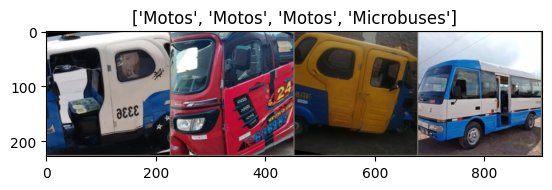

In [7]:
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  
  if title is not None:
    plt.title(title)
  plt.pause(0.001)
  
inputs, classes = next(iter(val_loader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

GPU para el enternamiento, verifico que se utilize CUDA
0-> para el primer gpu
1-> para seleccionar el segundo GPU en caso se tuviera

In [8]:
torch.cuda.set_device(0) 
device = ('cuda' if torch.cuda.is_available() else 'cpu')

print("Se entrenara con:", device)

Se entrenara con: cuda


Arquitectura de la red

In [9]:
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 256, kernel_size=3)    
    self.bn1 = nn.BatchNorm2d(256)    
    self.conv3 = nn.Conv2d(256, 512, kernel_size=3)
    #512 de la capa previa, 26 tamaño de la imagen
    self.fc1 = nn.Linear(512*26*26,50)  #Una capa full conected, 50 es el numero de neuronas q quiero 
    self.fc2 = nn.Linear(50,3) #son  clases
    
  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), 2)  #2 el tamaño de la ventana de pooling
    #x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = F.max_pool2d(F.relu(self.bn1(self.conv2(x))), 2)
    x = F.max_pool2d(F.relu(self.conv3(x)), 2)
    #x = F.relu(self.conv3(x)
    #x = x.view(-1,30*5*5) #al valor de x le hago un, -1 desdoblo las dimensiones a un size de 320
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.softmax(x)
  
  def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features 

network = Network()

In [10]:
network = network.to(device)

Función de entrenamiento para train y val

Se añade comentarios tomados de la documentación y foros explicando el proceso y parámetros utilizados

In [11]:
def train_model(model, criterio, optimizer, scheduler, num_epochs):  
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_acc_train = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 25)
    
        # Train model
        scheduler.step()
        model.train()
    
        running_loss = 0.0
        running_corrects = 0.0
    
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            optimizer.zero_grad()
        
            outputs = model(inputs)
            
            # Aplicar log_softmax para usar NLLLoss
            log_probs = F.log_softmax(outputs, dim=1)
            
            # Calcular la pérdida usando log_probs
            loss = criterio(log_probs, labels)
        
            loss.backward()
            optimizer.step()
        
            # Calcular predicciones
            _, preds = torch.max(log_probs, 1)
        
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss_train = running_loss / len(train_dataset)
        epoch_acc_train = running_corrects.double() / len(train_dataset)
    
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))
        if epoch_acc_train > best_acc_train:
              best_acc_train = epoch_acc_train
        
        # Validation 
        model.eval()
        running_loss = 0.0
        running_corrects = 0.0
    
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                
                # Aplicar log_softmax para validación
                log_probs = F.log_softmax(outputs, dim=1)
                
                # Calcular la pérdida
                loss = criterio(log_probs, labels)
                
                # Calcular predicciones
                _, preds = torch.max(log_probs, 1)
            
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss_val = running_loss / len(val_dataset)
        epoch_acc_val = running_corrects.double() / len(val_dataset)
                   
        print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))
                      
        if epoch_acc_val > best_acc:
              best_acc = epoch_acc_val
              best_model_wts = copy.deepcopy(model.state_dict())
              torch.save(best_model_wts, 'CP_nllloss.pth')  # Cambia el nombre para distinguirlo
              
    time_elapsed = time.time() - since
    print("####################################################")
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
    print('Best train accuracy: {:.4f}'.format(best_acc_train))
    print('Best val accuracy: {:.4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model


Funcion test

In [12]:
def test_model(model):
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            
            # Aplicar log_softmax para usar NLLLoss
            log_probs = F.log_softmax(outputs, dim=1)
            
            # Calcular la pérdida usando log_probs
            loss = criterion(log_probs, labels)
            
            # Calcular predicciones
            _, preds = torch.max(log_probs, 1)
            
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
            
    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects.double() / len(test_dataset)
        
    print('Test Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return model


Visualizar el resultado, se utiliza imagenes en test

In [13]:
def visualize_model(model, num_images):
    was_training = model.training
    
    model.eval()
    images_so_far = 0
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            # Aplicar log_softmax
            log_probs = F.log_softmax(outputs, dim=1)
            
            # Obtener predicciones
            _, preds = torch.max(log_probs, 1)
                    
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images, 1, images_so_far)
                
                ax.axis('off')
                ax.set_title('Predicted: {} (Clase: {})'.format(
                    class_names[preds[j]], class_names[labels[j]]))
                                
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return           
        
        model.train(mode=was_training)


torch.hub.list(github, force_reload=False, skip_validation=False)###Entrenamiento 1

Función de pérdida: CrossEntropyLoss

Optimizador: stochastic gradient descent SGD

In [14]:
import torch
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights

# Cargar VGG16 sin pesos preentrenados
model_vgg16 = vgg16(weights=None)

In [15]:
# Arquitectura del modeloM
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
num_ft = model_vgg16.classifier[-1].in_features
model_vgg16.classifier[-1] = nn.Linear(num_ft, 3)

In [17]:
# Modelo a GPU
model_vgg16 = model_vgg16.to(device)

In [18]:
# FUncion de perdidad, optimizador, LR
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Pruebo el entrenamiento con los datos de test

In [19]:
model_vgg16 = train_model(model_vgg16, criterion, optimizer, scheduler, num_epochs=num_epocas)

Epoch 0/19
-------------------------


/home/aloha/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Train Loss: 1.0785 Acc: 0.3894
Val Loss: 0.9902 Acc: 0.4667
Epoch 1/19
-------------------------
Train Loss: 1.0127 Acc: 0.4856
Val Loss: 0.9479 Acc: 0.5400
Epoch 2/19
-------------------------
Train Loss: 0.9648 Acc: 0.5094
Val Loss: 0.9224 Acc: 0.5800
Epoch 3/19
-------------------------
Train Loss: 0.9246 Acc: 0.5406
Val Loss: 0.8288 Acc: 0.5700
Epoch 4/19
-------------------------
Train Loss: 0.8662 Acc: 0.5806
Val Loss: 0.8038 Acc: 0.5967
Epoch 5/19
-------------------------
Train Loss: 0.8399 Acc: 0.6044
Val Loss: 0.7640 Acc: 0.6400
Epoch 6/19
-------------------------
Train Loss: 0.7745 Acc: 0.6422
Val Loss: 0.7110 Acc: 0.6667
Epoch 7/19
-------------------------
Train Loss: 0.7578 Acc: 0.6572
Val Loss: 0.6916 Acc: 0.6500
Epoch 8/19
-------------------------
Train Loss: 0.7340 Acc: 0.6728
Val Loss: 0.6203 Acc: 0.7133
Epoch 9/19
-------------------------
Train Loss: 0.7159 Acc: 0.6811
Val Loss: 0.6691 Acc: 0.6933
Epoch 10/19
-------------------------
Train Loss: 0.6905 Acc: 0.695

Visualización de resultados en test

In [20]:
model_vgg16_test = test_model(model_vgg16)

Test Loss: 0.6195 Acc: 0.7200


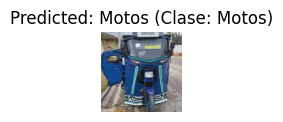

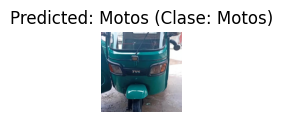

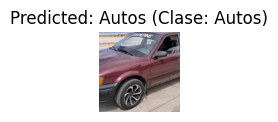

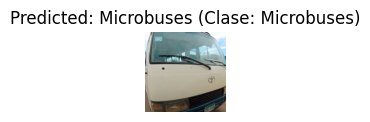

In [21]:
visualize_model(model=model_vgg16, num_images = 4)

In [22]:
import pandas as pd

# Datos para la tabla
data = {
    "Modelo": [
        "Modelo Propio CrossEntropy", "Modelo Propio NLLLoss", "Modelo Propio Smooth",
        "VGG16 sin pesos NLLLoss", "VGG16 con pesos NLLLoss",
        "ResNet101 con pesos CrossEntropy", "ResNet101 sin pesos CrossEntropy",
        "ResNet101 con pesos NLLLoss", "ResNet101 sin pesos NLLLoss",
        "ResNet101 con pesos Smooth", "ResNet101 sin pesos Smooth",
        "ResNet50 con pesos CrossEntropy", "ResNet50 sin pesos CrossEntropy",
        "ResNet50 con pesos NLLLoss", "ResNet50 sin pesos NLLLoss",
        "ResNet50 con pesos Smooth", "ResNet50 sin pesos Smooth"
    ],
    "Accuracy (%)": [
        "73.3", "84.6", "80.0",
        "72.0", "98.0",
        "97.67", "65.33",
        "98.0", "65.0",
        "97.33", "59.67",
        "98.33", "70.0",
        "98.33", "69.67",
        "98.67", "66.67"
    ],
    "Loss": [
        "-", "-", "-",
        "0.61", "0.1",
        "0.0752", "0.8149",
        "0.0749", "0.7880",
        "0.0645", "0.5279",
        "0.0862", "1.0778",
        "0.0869", "0.6800",
        "0.1002", "0.4967"
    ]
}

# Crear DataFrame
df = pd.DataFrame(data)

# Mostrar DataFrame
import ace_tools as tools; tools.display_dataframe_to_user(name="Resultados de Test de Modelos", dataframe=df)


ModuleNotFoundError: No module named 'ace_tools'